## Problem Statement
Given the dataset from the Open University, the task is to figure out how the student learning data can be best utilized or leveraged to improve outcomes. 

## Dataset Description
Open University Learning Analytics Dataset (OULAD) contains data about courses, students and their interactions with Virtual Learning Environment (VLE) for seven selected courses (called modules). Presentations of courses start in February and October - they are marked by "B" and "J" respectively. The dataset consists of tables connected using unique identifiers. 

**Open University** : The Open University is one of the largest distance learning universities worldwide. Teaching materials and other content are delivered to students via the VLE. Students’ interactions with the educational materials are recorded and stored in university data warehouse.


## Areas explored by the analysis

1. Biggest Problem Space in Virtual learning at Open University
2. Dimensions that have the highest failure rate or withdrawal rate
3. Recommend efficient solution to minimize failure

## Exploratory data analysis

Preprocessing

- Using one-hot encoding for results (distinction, pass, fail, withdraw)
- Mark categorical features like gender, region and others that can take values from a fixed set but do not have ranking between values
- Mark ordinal features for education level where the values can be from a fixed set of values with a fixed order. ie. No Formal quals < Lower Than A Level < A Level or Equivalent and so on.
 
Visualization
- Summarizing insights like number of modules, courses, students, VLE engagements etc.
- Plotting distribution of various features to understand the data

Summary
7 modules are being offered in 22 presentations (3.14 presentations per module)
32593 registrations from 28785 students (1.13 registrations per student)
10655280 VLE engagements per student per course in a day with 6364 VLEs (1674.31 interactions per VLE)


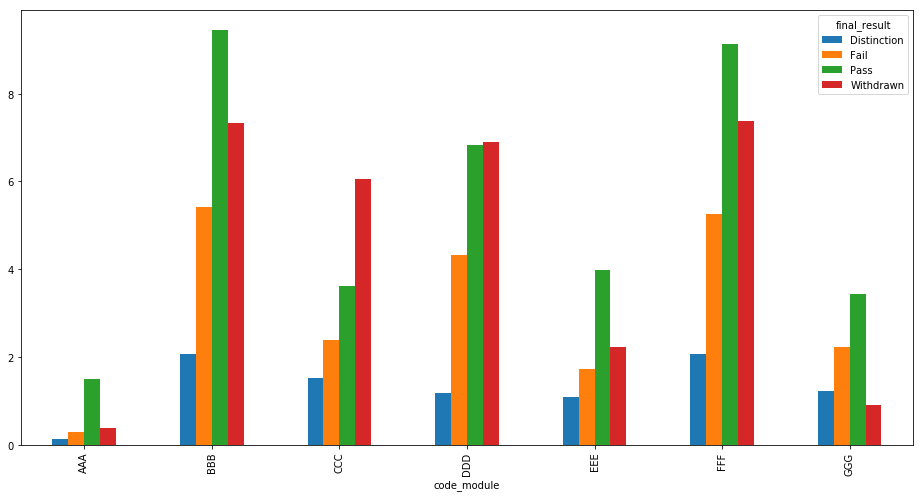

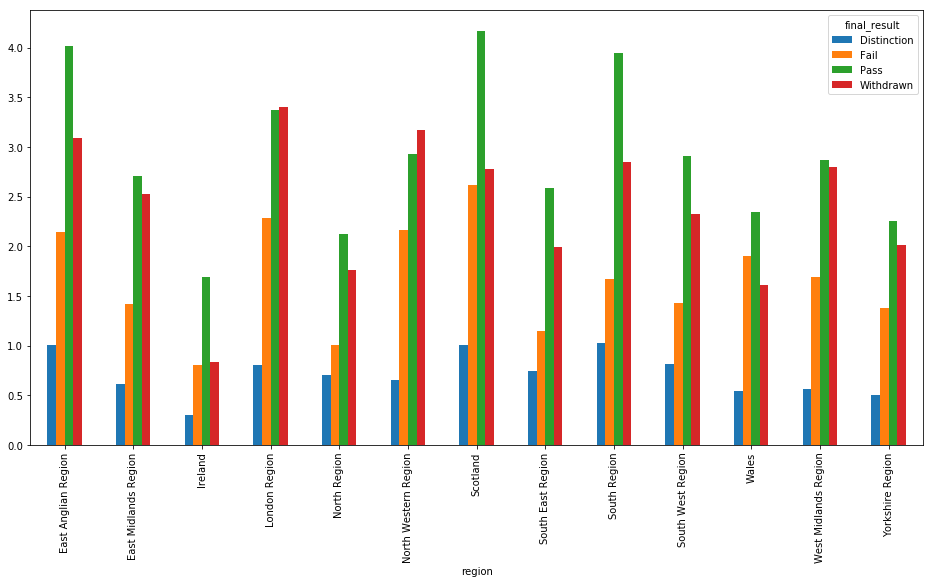

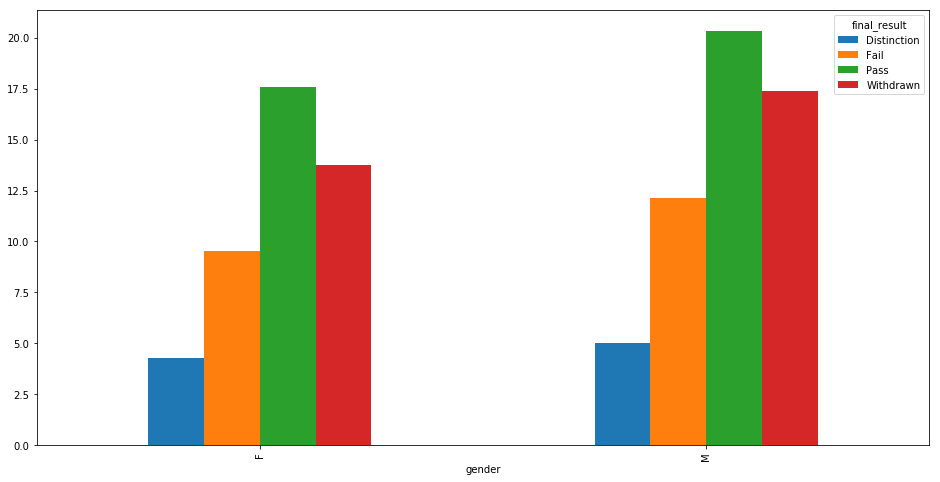

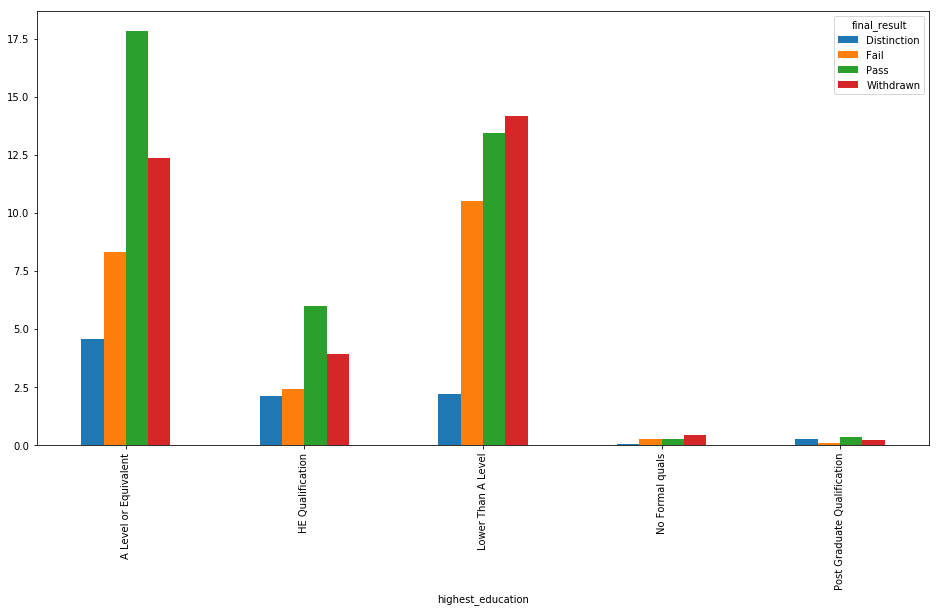

In [1]:
# Data summary and visualization

import matplotlib
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing

# Read data into memory
student_info = pd.read_csv("studentInfo.csv")
assessments = pd.read_csv("assessments.csv")
student_assessment = pd.read_csv("studentAssessment.csv")
courses = pd.read_csv("courses.csv")
student_registration = pd.read_csv("studentRegistration.csv")
student_vle = pd.read_csv("studentVle.csv")
vle = pd.read_csv("vle.csv")

num_modules = courses.code_module.nunique()
num_presentations = courses.code_presentation.count()
num_students = student_info.id_student.nunique()
num_registrations = student_registration.id_student.count()
num_interactions = student_vle.id_site.count()
num_vles = vle.id_site.count()

print ("Summary")
print ("{0} modules are being offered in {1} presentations ({2} presentations per module)"
       .format(num_modules, num_presentations, round(num_presentations / num_modules, 2)))
print ("{0} registrations from {1} students ({2} registrations per student)"
       .format(num_registrations, num_students, round(num_registrations / num_students, 2)))
print ("{0} VLE engagements per student per course in a day with {1} VLEs ({2} interactions per VLE)"
       .format(num_interactions, num_vles, round(num_interactions / num_vles, 2)))

# Visualize pass, fail and withdrawn percentages
% matplotlib inline
visualization_fields = ['code_module', 'region', 'gender', 'highest_education']
for field in visualization_fields:
    pd.crosstab(student_info[field], student_info['final_result']).apply(lambda r: (r / len(student_info)) * 100,
                                                                         axis=1).plot.bar(figsize=(16, 8))

### Key insights

- 31.1% of students withdraw the course followed by 21.6% of students failing.  Therefore, out of the total students registering for the course, only 50% of students registered pass the exam which signifies a problem of lower successful completion of course by the students in the virtual learning environment.
- Each student registers for approximately one course (1.1 to be specific).
- There is a high correlation between number of clicks and the final result of the student which can be leveraged to improve the prediction outcome.

***Summary from  exploratory data analysis ***

1. Students are distributed over the geographical regions and not concentrated over a few areas.
2. A Level, is a secondary school leaving qualification in the United Kingdom. Maximum number of students taking the online courses have A level education or lower. 
3. Maximum people registering for the courses are in the age group 0-35. There are very less students in the age group above than 55.
4. 30% of students submit assessment late.

In [2]:
# Pre processing and calculating correlation between fields

# Parse Index of Multiple Depravation band replacing 0 with 50 (average score).
student_info['imd_band'] = student_info['imd_band'].str.split('-').str[0]
student_info['imd_band'] = student_info.replace({'imd_band': {'?': 50}})['imd_band'].astype('int')
student_info = student_info.replace({'age_band': {'0-35': 25, '35-55': 45, '55<=': 65}})

# Replace missing dates with 0.
assessments['date'] = assessments['date'].replace(['?'], '0').astype('int')
student_vle['date'] = student_vle['date'].replace(['?'], '0').astype('int')

# One hot encoding for final result, keeping the original result column for used.
dummies = pd.get_dummies(student_info['final_result'])
student_info = pd.concat([student_info, dummies], axis=1)
for col in ["code_module", "code_presentation"]:
    student_vle[col] = student_vle[col].astype('category')

# Unordered categorical labeling for fields that have no order for ranking values.
for col in ["gender", "region", "disability"]:
    student_info[col] = student_info[col].astype('category')

# Ordinal labeling for highest education based on degree level.
student_info = student_info.replace({'highest_education': {'No Formal quals': 0,
                                                           'Lower Than A Level': 1,
                                                           'A Level or Equivalent': 2,
                                                           'HE Qualification': 3,
                                                           'Post Graduate Qualification': 4}})

# Calculate correlation between columns
print(pd.merge(student_info,
               student_vle.groupby(["code_module", "code_presentation", "id_student"], as_index=False)[
                   'sum_click'].sum(),
               on=['code_module', 'code_presentation', 'id_student']).corr())

                      id_student  highest_education  imd_band  age_band  \
id_student              1.000000           0.042191  0.024396  0.198493   
highest_education       0.042191           1.000000  0.125717  0.110026   
imd_band                0.024396           0.125717  1.000000  0.071579   
age_band                0.198493           0.110026  0.071579  1.000000   
num_of_prev_attempts    0.012470          -0.041709 -0.040758  0.005033   
studied_credits        -0.006083           0.010024 -0.037872 -0.075143   
Distinction             0.028164           0.127624  0.086055  0.064893   
Fail                   -0.032051          -0.098357 -0.082725 -0.053291   
Pass                    0.003417           0.062797  0.070033  0.029214   
Withdrawn               0.007341          -0.064971 -0.059340 -0.026833   
sum_click               0.037327           0.082098  0.077465  0.140429   

                      num_of_prev_attempts  studied_credits  Distinction  \
id_student             

## Predicting final outcome using predictive analysis

### Decision Tree Classifier
Decision tree learning is used to link module, presentation and student's engagement with VLEs represented in the tree’s branches to conclude upon the student result for a classification tree. Using a tree with max_depth=5 as the default values in sklearn lead to fully grown and unpruned trees which can be very large on this data set causing huge memory consumption and overfitting.

### Random Forest Classifier
Since we have a lot of features that do not show very strong correlation with the label, we use Random Forest as an algorithm that handles large number of features and can help in estimating which of variables are important in the underlying data being modeled.

> Note: Using the exact score data instead of just result (pass, fail, distinction, withdraw) combined with leveraging information on assessment type (tutor-marked assignments - TMAs v/s computer-marked assignments - CMAs) v/s Exam would give more representational data for training and helps in building a regression tree, which would take much higher memory to train.

In [3]:
# Model Training and evaluation

# Prepare dataset for training

# Merge assessments and student assessments data on Assessment ID
student_assessment_merged = pd.merge(assessments, student_assessment, on='id_assessment')

# Merge relevant columns from student info to the temp table
student_assessment_course_merged = pd.merge(student_info, student_assessment_merged,
                                            on=['code_module', 'code_presentation', 'id_student'])

# Analyzing late submissions
num_late_submission = student_assessment_course_merged[
    student_assessment_course_merged['date_submitted'] > student_assessment_course_merged['date']]['date'].count()
total_submissions = student_assessment_course_merged['date'].count()
print("Percentage of late submissions: ", num_late_submission / total_submissions * 100)

# Merge student_assessment_merged with student_vle table to analyze the score with respect to student's interaction with VLE
clicks_analysis = pd.merge(student_vle, student_assessment_merged,
                           on=['code_module', 'code_presentation', 'id_student'])

# Filter rows with where Student Vle Date <= Assessment Date
clicks_analysis_filtered = clicks_analysis[clicks_analysis['date_x'] <= clicks_analysis['date_y']].groupby(
    ["code_module", "code_presentation", "id_student", "assessment_type"], as_index=False)['sum_click'].sum()

# Number of clicks per day by student until assessment submission
clicks_analysis_filtered['sum_click_rate'] = clicks_analysis_filtered['sum_click'] / clicks_analysis['date_submitted']
print(clicks_analysis_filtered.head())


predictive_analysis = pd.merge(student_info, clicks_analysis_filtered,
                               on=['code_module', 'code_presentation', 'id_student'])

# Encode labels with value between 0 and n_classes-1.
le = preprocessing.LabelEncoder()
categorical_features = ['gender', 'code_module', 'code_presentation', 'region', 'disability']
for feature in categorical_features:
    le.fit(predictive_analysis[feature])
    predictive_analysis[feature] = le.transform(predictive_analysis[feature])

# Insight: Average click rate for students by results.
print(predictive_analysis.groupby(['final_result'])['sum_click_rate'].mean())

# Build the feature set and and define the class to predict
# We cannot use id_student in the model features as we should be able to predict for new students
Y = predictive_analysis["final_result"]
X = predictive_analysis[['sum_click_rate', 'code_module']]
# Train/test split.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=1)

# Fit the model
classifiers = [
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=2),
]
for clf in classifiers:
    clf.fit(X_train, Y_train)
    # Calculate Accuracy of Classifier
    print(clf)
    print(clf.score(X_test, Y_test))


Percentage of late submissions:  30.0054050324
  code_module code_presentation  id_student assessment_type  sum_click  \
0         AAA             2013J       11391             TMA       3062   
1         AAA             2013J       28400             TMA       4543   
2         AAA             2013J       31604             TMA       6032   
3         AAA             2013J       32885             TMA       3595   
4         AAA             2013J       38053             TMA       6213   

   sum_click_rate  
0      139.181818  
1       87.365385  
2       49.851240  
3       21.920732  
4       29.306604  
final_result
Distinction    163.484992
Fail            46.304057
Pass           123.113173
Withdrawn       23.518067
Name: sum_click_rate, dtype: float64
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fractio

## Conclusion and Future Work

### Conclusion

Interactions with VEs seems to be the most important factor in determining student performance.

| Performance | Average click per day|
| ------------- |:-------------:|
| Distinction | 163.48 |
| Pass | 123.11 |
| Fail | 46.30 |
| Withdrawn | 23.51 |

This shows that high performing students are way more likely to click VLEs.

- Using factors like gender, region, age in the decision tree did not improve the results, possibilty causing an overfit.


### Recommendations
Increasing engagement with VLEs should lead to improvement in results. This can be done by one or more of the following

- Planning VLEs releases
  - Comparing VLEs released on weekdays v/s weekends
  - Choosing time of day to release VLEs when there is higher chances of getting clicked, thereby increasing student engagement

- During course
  - Asking multiple choice questions in between the course interaction will help students to engage more with the presentation
  - More visual content to drive engagement

- After class
  - Sending email to students when course to drive re-engagement
  - A/B testing with VLE content, placement and schedule


### Future work

- More fine-grained VLE representation for the model. Since VLE interaction is the single most representative factor in our model so far, next logical step would be the following.
  - Leveraging type of VLE information. ie. treating resource v/s oucontent v/s dataplus as different VLEs for our model and not just using the sum of click across all VLE types. An intuition here is that visual content is more likely to get engagement compared to text. This can be tested and used to get better student results making courses more effective.
  - Leveraging time of publishing of VLEs and time of VLE interaction to understand patterns (weekday v/s weekend or time of the day) for different types of VLEs.

- More accurate scoring
  - Using the actual score instead of just pass/fail information
  - Understanding performance of the student over the time of the module presentation, instead of just using the grade at the end for a better performance representation.

- Running analysis on cloud instance
  - We trained a simple classification tree, including the above richer information would help in training a regression tree. Such analysis would have to run on a cloud instance as it would require more computation resources.